In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from torch.distributions import Normal, LogNormal
import scipy.io as sio
import h5py

# [Mixture Density Network(MDN)](https://publications.aston.ac.uk/id/eprint/373/1/NCRG_94_004.pdf)
In the following sections, I generated the sample points in the paper and tried to use the MDN model to fit the distribution.


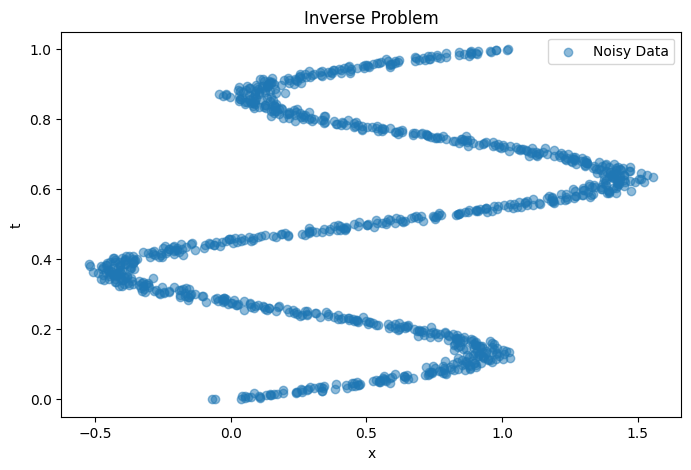

In [3]:
def data_generator():
    t = np.linspace(0, 1, 1000)
    # Add noise (Gaussian)
    noise = np.random.normal(0, 0.05, size=t.shape)  # mean=0, std=0.05

    # Compute x using the formula
    x = t + 0.8 * np.sin(4 * np.pi * t) + noise
    return x.reshape(-1,1), t.reshape(-1,1)

x_train, y_train = data_generator()

# Plot the data with shaded std deviation
plt.figure(figsize=(8, 5))
plt.scatter(x_train, y_train, alpha=0.5, label="Noisy Data")
plt.xlabel("x")
plt.ylabel("t")
plt.legend()
plt.title("Inverse Problem")
plt.show()

Defining the MDN model using torch. Basically, in the MDN model, we try to use multiple Gaussians (`num_gaussians`) to fit our distribution.
The number of inputs is one (x), and the number of outputs is 3 $\times$ `num_gaussians` (i.e., finding $\pi, \mu, \sigma$ for each gaussian). $\pi$ is the weight of each gaussian $\Sigma_{i}^{\text{num-gauss}} \pi_{i} =1$. `ReLU` is used as an activation function. `h` is the output of the fully connected Neural Network with 32 outputs. Now `h` goes into different fully connected neural networks to give $\pi, \mu, \sigma$ separately. Since summation of $\pi$ should be one, `self.pi_layer` goes into a `softmax` function for that variable. For `mu`, it is just out of 32 to 5 fully connected layer. Since sigma should be positive, after the fully connected 32 to 5 layer, `exp()` of the output is introduced as the $\sigma$.

In [4]:
# Define the Mixture Density Network
class MDN(nn.Module):
    def __init__(self, *, input_dim=1, num_gaussians=5):
        super(MDN, self).__init__()
        self.num_gaussians = num_gaussians
        self.fc = nn.Sequential(
            nn.Linear(input_dim, 32),
            nn.ReLU(),
            nn.Linear(32, 32),
            nn.ReLU(),
            nn.Linear(32, 32),
            nn.ReLU(),
            nn.Linear(32, 32),
            nn.ReLU(),
            nn.Linear(32, 32),
            nn.ReLU()
        )
        self.pi_layer = nn.Linear(32, num_gaussians)  # Mixing coefficients
        self.mu_layer = nn.Linear(32, num_gaussians)  # Means of Gaussians
        self.sigma_layer = nn.Linear(32, num_gaussians)  # Standard deviations
    
    def forward(self, x):
        h = self.fc(x)
        pi = torch.softmax(self.pi_layer(h), dim=1)  # Mixing coefficients (softmax)
        mu = self.mu_layer(h)  # Means
        sigma =  torch.exp(self.sigma_layer(h)).clamp(min=0.005)  # Standard deviations (exp for positivity)
        return pi, mu, sigma



The negative log-likelihood technique is used for the loss function. Basically, after generating the $\mu, \sigma, \pi$ from one input `x`, we can find the likelihood of the output `y` based on the generated $\mu, \sigma, \pi$. This procedure is repeated for all samples in the dataset using the `Adam` optimizer, which is based on `SGD`. Then total loss for all input parameters is computed, and then backward propagation is started.

In [5]:
# Define the Negative Log Likelihood loss for MDN
def mdn_loss(pi, mu, sigma, y, disttype = "Normal"):
    y = y.expand(-1, mu.shape[-1])  # Fix dimension expansion
    if disttype == "Normal":
        normal_dist = Normal(mu, sigma)
        likelihoods = torch.exp(normal_dist.log_prob(y))  # Due to numerical instability we first take a log and then exp
    else:
        log_normal_dist = LogNormal(mu, sigma)
        likelihoods = torch.exp(log_normal_dist.log_prob(y))
    weighted_likelihoods = pi * likelihoods  # Weight by mixing coefficients
    loss = -torch.log(weighted_likelihoods.sum(dim=1) + 1e-8).mean()  # Log sum exp trick
    return loss

## Start training

In [12]:
# Training the model
x_train = torch.tensor(x_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)

sample_model = MDN(input_dim = 1, num_gaussians = 8)
optimizer = optim.Adam(sample_model.parameters(), lr=0.01)

# Training loop
epochs = 10000
for epoch in range(epochs):
    optimizer.zero_grad()
    pi, mu, sigma = sample_model(x_train)
    dist_type = "Normal"
    loss = mdn_loss(pi, mu, sigma, y_train, dist_type)
    loss.backward()
    optimizer.step()
    if epoch % 50 == 0:
        print(f'Epoch {epoch}, Loss: {loss.item():.4f}')

C:\Users\ehsan010\AppData\Local\Temp\ipykernel_13100\701845873.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_train = torch.tensor(x_train, dtype=torch.float32)
C:\Users\ehsan010\AppData\Local\Temp\ipykernel_13100\701845873.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train = torch.tensor(y_train, dtype=torch.float32)


Epoch 0, Loss: 1.0403
Epoch 50, Loss: -0.2699
Epoch 100, Loss: -0.6449
Epoch 150, Loss: -0.7795
Epoch 200, Loss: -0.8602
Epoch 250, Loss: -0.6843
Epoch 300, Loss: -0.8758
Epoch 350, Loss: -0.8896
Epoch 400, Loss: -0.8549
Epoch 450, Loss: -1.0999
Epoch 500, Loss: -1.1343
Epoch 550, Loss: -1.0340
Epoch 600, Loss: -0.2141
Epoch 650, Loss: -1.0477
Epoch 700, Loss: -1.2975
Epoch 750, Loss: -1.2855
Epoch 800, Loss: -1.4786
Epoch 850, Loss: -1.4663
Epoch 900, Loss: -1.8505
Epoch 950, Loss: -1.4125
Epoch 1000, Loss: -1.4411
Epoch 1050, Loss: -1.8503
Epoch 1100, Loss: -1.8959
Epoch 1150, Loss: -1.9803
Epoch 1200, Loss: -1.6933
Epoch 1250, Loss: -1.8764
Epoch 1300, Loss: -2.0270
Epoch 1350, Loss: -2.0946
Epoch 1400, Loss: -2.1011
Epoch 1450, Loss: -2.0898
Epoch 1500, Loss: -2.0475
Epoch 1550, Loss: -2.0977
Epoch 1600, Loss: -2.0612
Epoch 1650, Loss: -2.1217
Epoch 1700, Loss: -2.1150
Epoch 1750, Loss: -2.1151
Epoch 1800, Loss: -2.0665
Epoch 1850, Loss: -2.0936
Epoch 1900, Loss: -2.1350
Epoch 1950

In the following functions, we sample `num_samples` for each generated value in `x_test`. In `final_pdf` we use the $\mu, \sigma, \pi$ corresponds to the generated random value `x_test` to find the final p.d.f. which is combination of all `num_gaussian` p.d.f.s. Then in `sample_from_combined_pdf` we take `num_samples` samples randomly sampled from the final p.d.f.

In [10]:
# Final PDF calculation function
def final_pdf(pi, mu, sigma, x, disttype="Normal"):
    pdf_values = torch.zeros(x.shape[0], pi.shape[1])  # [1000, num_gaussians]
    
    # Compute the individual PDF values for each Gaussian component
    for i in range(pi.shape[1]):  # num_gaussians
        if disttype=="Normal":
            dist = Normal(mu[:, i], sigma[:, i])
            pdf_values[:, i] = dist.log_prob(x).exp()  # Exponentiate to get the actual PDF
        else:
            dist = LogNormal(mu[:, i], sigma[:, i])
            pdf_values[:, i] = dist.log_prob(x).exp()  # Exponentiate to get the actual PDF
    
    # Weight the PDFs by the mixing coefficients (pi)
    weighted_pdf = pdf_values * pi  # Broadcasting pi across [1000, num_gaussians]
    
    # Sum the weighted PDFs over all components
    final_pdf_values = weighted_pdf.sum(dim=1)  
    # for Nomral torch.trapz(final_pdf_values, x) must be 1
    # for LogNormal torch.trapz(final_pdf_values, x) must be 1
    return final_pdf_values

# Sampling from the combined PDF based on the learned model parameters
def sample_from_combined_pdf(pi, mu, sigma, num_samples=100, disttype="Normal"):
    # print(num_samples)
    """
    Sample 'num_samples' values from the final combined distribution using the CDF.
    pi: mixing coefficients (num_gaussians)
    mu: means of the num_gaussians
    sigma: standard deviations of the num_gaussians
    num_samples: number of samples to generate (default is 100)
    """
    if disttype=="Normal":
        x_values = torch.linspace(-10, 10, steps=1000)  # Define the range for sampling
    else:
        x_values = torch.logspace(-5, 5, steps=1000)  # Define the range for sampling

    
    pdf_values = final_pdf(pi, mu, sigma, x_values, disttype)  # Compute the PDF
    
    # Normalize the PDF to get the CDF
    cdf_values = torch.cumsum(pdf_values, dim=0)
    cdf_values = cdf_values / cdf_values[-1]  # Normalize so that CDF ends at 1
    
    # Generate 'num_samples' random values to sample from the CDF
    u = torch.rand(num_samples)  # Generate random values to sample from the CDF
    
    samples = []
    for val in u:
        sample_index = (cdf_values > val).nonzero(as_tuple=True)[0][0].item()
        sample = x_values[sample_index]
        samples.append(sample)
    
    return torch.tensor(samples)



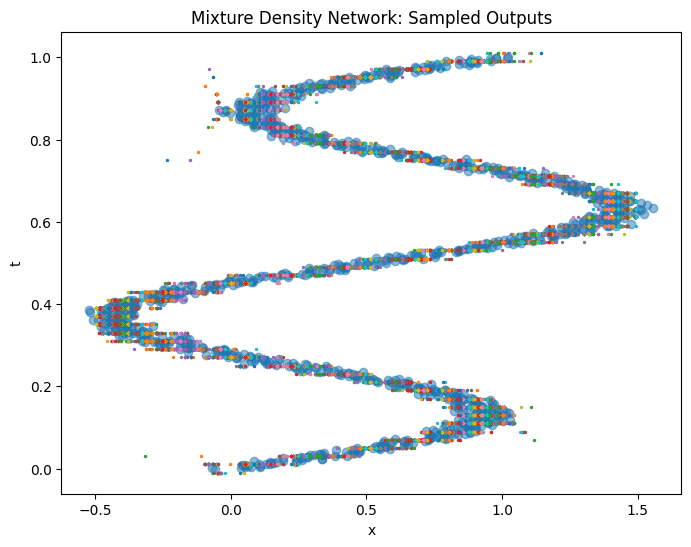

In [13]:
# Example usage:
x_test = torch.rand(500, 1)*2-0.5  # 500 values of x_test (batch of 500)
pi, mu, sigma = sample_model(x_test)  # Get the corresponding pi, mu, sigma

# Sample 'num_samples' values for each of the 500 x_test values
num_samples = 50  # Input parameter for number of samples to generate
y_samples = []

for i in range(x_test.shape[0]):
    dist_type = "Normal"
    y_samples.append(sample_from_combined_pdf(pi[i:i+1, :], mu[i:i+1, :], sigma[i:i+1, :], num_samples,disttype = dist_type).detach().numpy())

# Plotting the results
plt.figure(figsize=(8, 6))
plt.scatter(x_train.numpy(), y_train.numpy(), alpha=0.5, label='Training Data')

# Loop over x_test and corresponding y_samples to plot individual samples
for i, y_s in enumerate(y_samples):
    plt.scatter(np.repeat(x_test[i].numpy(), num_samples), y_s, s=2, label=f'Sample {i+1}')

plt.title('Mixture Density Network: Sampled Outputs')
plt.xlabel('x')
plt.ylabel('t')
plt.show()

In the next section, the performance of MDN model on the logarithmically distributed data is tested. Between `1e-1` to `1e1`, 1000 samples with the same logarithmic increment are generated. Most of the samples are generated between `1e-1` to `1e0`

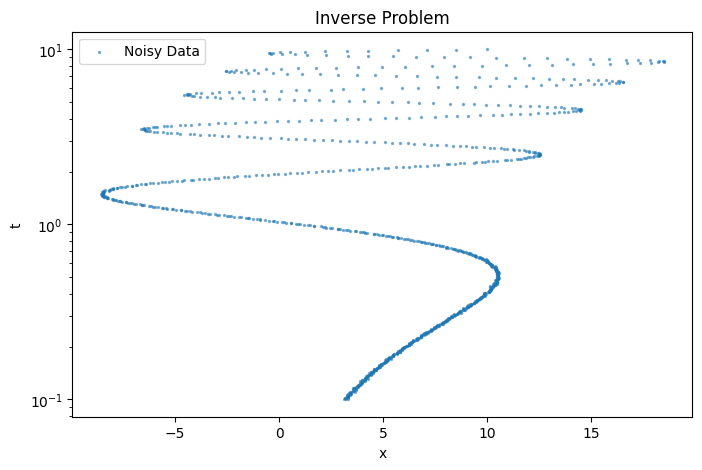

In [14]:
def log_data_generator():
    t = np.logspace(-1,1,1000)  # from 1e-1 to 1e1 seconds, 1000 points
    # Add noise (Gaussian)
    noise = np.random.normal(0, 0.05, size=t.shape)  # mean=0, std=0.05

    # Compute x using the formula
    x = t + 10 * np.sin(1 * np.pi * t) + noise
    return x.reshape(-1,1), t.reshape(-1,1)

x_train, y_train = log_data_generator()

# Plot the data with shaded std deviation
plt.figure(figsize=(8, 5))
plt.scatter(x_train, y_train, alpha=0.5, label="Noisy Data",s=2)
plt.xlabel("x")
plt.ylabel("t")
plt.yscale('log')
plt.legend()
plt.title("Inverse Problem")
plt.show()

Plotted `log(y)` in `yscale('linear')`

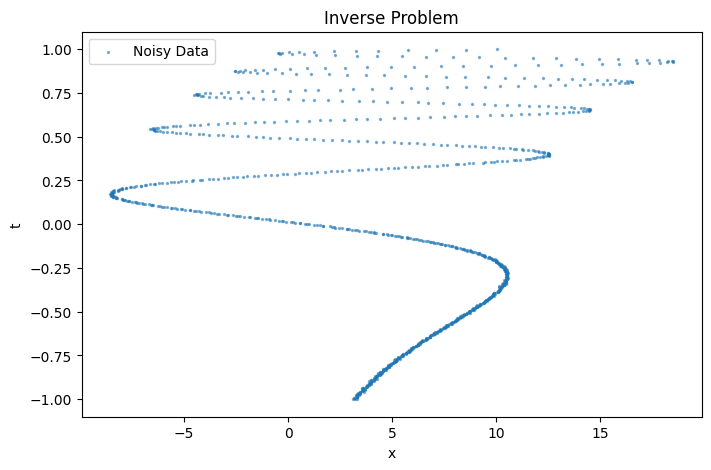

In [15]:
# Plot the data with shaded std deviation
plt.figure(figsize=(8, 5))
plt.scatter(x_train, np.log10(y_train), alpha=0.5, label="Noisy Data",s=2)
plt.xlabel("x")
plt.ylabel("t")
plt.legend()
plt.title("Inverse Problem")
plt.show()

## Start Training the Model

In [16]:
x_train, y_train = log_data_generator()
x_train = torch.tensor(x_train, dtype=torch.float32)
y_train = torch.tensor(np.log(y_train), dtype=torch.float32)

sample_model_log = MDN(input_dim=1,num_gaussians=100)
optimizer = optim.Adam(sample_model_log.parameters(), lr=0.01)

# Training loop
epochs = 10000
for epoch in range(epochs):
    optimizer.zero_grad()
    pi, mu, sigma = sample_model_log(x_train)
    dist_type = "Normal"
    loss = mdn_loss(pi, mu, sigma, y_train, dist_type)
    loss.backward()
    optimizer.step()
    if epoch % 50 == 0:
        print(f'Epoch {epoch}, Loss: {loss.item():.4f}')

Epoch 0, Loss: 1.7924
Epoch 50, Loss: 1.1698
Epoch 100, Loss: 0.4772
Epoch 150, Loss: -0.0535
Epoch 200, Loss: 0.2177
Epoch 250, Loss: -0.2264
Epoch 300, Loss: -0.0337
Epoch 350, Loss: 0.1119
Epoch 400, Loss: -0.7100
Epoch 450, Loss: 0.3645
Epoch 500, Loss: -0.6186
Epoch 550, Loss: -0.2057
Epoch 600, Loss: -0.4624
Epoch 650, Loss: -0.6062
Epoch 700, Loss: -0.3843
Epoch 750, Loss: -0.7596
Epoch 800, Loss: 1.2860
Epoch 850, Loss: -0.7589
Epoch 900, Loss: -0.4240
Epoch 950, Loss: -0.5963
Epoch 1000, Loss: -1.0592
Epoch 1050, Loss: -0.7515
Epoch 1100, Loss: -0.7397
Epoch 1150, Loss: 0.3278
Epoch 1200, Loss: -0.9672
Epoch 1250, Loss: -1.0684
Epoch 1300, Loss: -0.7067
Epoch 1350, Loss: -0.2932
Epoch 1400, Loss: -1.0170
Epoch 1450, Loss: -1.1362
Epoch 1500, Loss: -1.3672
Epoch 1550, Loss: -1.0397
Epoch 1600, Loss: -0.6623
Epoch 1650, Loss: -1.3282
Epoch 1700, Loss: -1.1558
Epoch 1750, Loss: -1.4106
Epoch 1800, Loss: -1.4543
Epoch 1850, Loss: -1.5107
Epoch 1900, Loss: -1.5994
Epoch 1950, Loss:

Plot samples taken out of the model

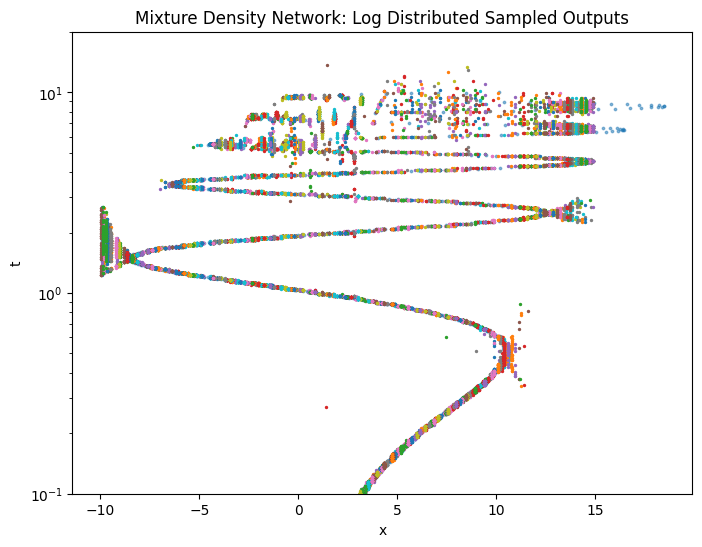

In [17]:
# Example usage:
x_test = torch.rand(500, 1)*25-10  # 500 values of x_test (batch of 500)
pi, mu, sigma = sample_model_log(x_test)  # Get the corresponding pi, mu, sigma

# Sample 'num_samples' values for each of the 500 x_test values
num_samples = 50  # Input parameter for number of samples to generate
y_samples = []

for i in range(x_test.shape[0]):
    dist_type = "Normal"
    y_samples.append(sample_from_combined_pdf(pi[i:i+1, :], mu[i:i+1, :], sigma[i:i+1, :], num_samples,disttype = dist_type).detach().numpy())

# Plotting the results
plt.figure(figsize=(8, 6))
plt.scatter(x_train.numpy(), np.exp(y_train.numpy()), alpha=0.5, label='Training Data',s=3)

# Loop over x_test and corresponding y_samples to plot individual samples
for i, y_s in enumerate(y_samples):
    plt.scatter(np.repeat(x_test[i].numpy(), num_samples), np.exp(y_s), s=2, label=f'Sample {i+1}')

plt.title('Mixture Density Network: Log Distributed Sampled Outputs')
plt.xlabel('x')
plt.ylabel('t')
plt.ylim(1e-1, 2e1)
plt.yscale('log')
plt.show()

## Read Hotwire data
The size of the `jpdfs_HotWT7.mat` files is more than 100 mb so I could not upload it to the repository. Email `ehsan010@umn.edu` in case you need the file. 

In [6]:
HotWireWT7 = h5py.File(r'jpdfs_HotWT7.mat','r')
T_domain_WT7 = np.array(HotWireWT7.get('T_domain_WT7')).T
X_domain_WT7 = np.array(HotWireWT7.get('X_domain_WT7')).T
res_WT7 = np.array(HotWireWT7.get('res_WT7'))

VF_HotWT7_u_tau = 0.39


duNN_refs = HotWireWT7['duNN_HotWT7']
maxmin_pairs_cell_HotWT7_refs = HotWireWT7['value_pairs_cell_HotWT7']
duwrtlocalmaxmin_HotWT7_refs = HotWireWT7['duwrtlocalmaxmin_HotWT7']

# To dereference:
duNN_HotWT7_list = []

for ref in duNN_refs:
    # Iterate over each element inside 'ref'
    for i, subref in enumerate(ref):
        # subref is now a real HDF5 reference
        dereferenced_data = HotWireWT7[subref]
        array_data = np.array(dereferenced_data)
        duNN_HotWT7_list.append(array_data)

duwrtlocalmaxmin_HotWT7_list = []

for ref in duwrtlocalmaxmin_HotWT7_refs:
    # Iterate over each element inside 'ref'
    for i, subref in enumerate(ref):
        # subref is now a real HDF5 reference
        dereferenced_data = HotWireWT7[subref]
        array_data = np.array(dereferenced_data)
        duwrtlocalmaxmin_HotWT7_list.append(array_data)

maxmin_pairs_HotWT7_list = []

for ref in maxmin_pairs_cell_HotWT7_refs:
    # Iterate over each element inside 'ref'
    for i, subref in enumerate(ref):
        # subref is now a real HDF5 reference
        dereferenced_data = HotWireWT7[subref]
        array_data = np.array(dereferenced_data)
        maxmin_pairs_HotWT7_list.append(array_data)


min_values = maxmin_pairs_HotWT7_list[0][1]/VF_HotWT7_u_tau
max_values = maxmin_pairs_HotWT7_list[0][0]/VF_HotWT7_u_tau

Making the object `Given_min_model` to find the distribution of maximum extremums given the minimum extremums(Fig4.).

In [ ]:
Given_min_model = MDN(input_dim= 1,num_gaussians= 5)
optimizer = optim.Adam(Given_min_model.parameters(), lr=0.01)

x_train = torch.tensor(min_values.reshape(-1,1), dtype=torch.float32)
y_train = torch.tensor(max_values.reshape(-1,1), dtype=torch.float32)

In [ ]:
# Training loop
epochs = 10000
for epoch in range(epochs):
    optimizer.zero_grad()
    pi, mu, sigma = Given_min_model(x_train)
    dist_type = "Normal"
    loss = mdn_loss(pi, mu, sigma, y_train, dist_type)
    loss.backward()
    optimizer.step()
    if epoch % 50 == 0:
        print(f'Epoch {epoch}, Loss: {loss.item():.4f}')

Epoch 0, Loss: 2.7496
Epoch 50, Loss: 1.2718
Epoch 100, Loss: 1.2198
Epoch 150, Loss: 1.1529
Epoch 200, Loss: 1.1492
Epoch 250, Loss: 1.1593
Epoch 300, Loss: 1.1234
Epoch 350, Loss: 1.1321
Epoch 400, Loss: 1.1244
Epoch 450, Loss: 1.1284
Epoch 500, Loss: 1.1598
Epoch 550, Loss: 1.1239
Epoch 600, Loss: 1.1638
Epoch 650, Loss: 1.1205
Epoch 700, Loss: 1.1202
Epoch 750, Loss: 1.1491
Epoch 800, Loss: 1.1334
Epoch 850, Loss: 1.1430
Epoch 900, Loss: 1.1295
Epoch 950, Loss: 1.1293
Epoch 1000, Loss: 1.1216
Epoch 1050, Loss: 1.1190
Epoch 1100, Loss: 1.1222
Epoch 1150, Loss: 1.1087
Epoch 1200, Loss: 1.1138
Epoch 1250, Loss: 1.1206
Epoch 1300, Loss: 1.1169
Epoch 1350, Loss: 1.1291
Epoch 1400, Loss: 1.1251
Epoch 1450, Loss: 1.1176
Epoch 1500, Loss: 1.1577
Epoch 1550, Loss: 1.1198
Epoch 1600, Loss: 1.1188
Epoch 1650, Loss: 1.1369
Epoch 1700, Loss: 1.1197
Epoch 1750, Loss: 1.1541
Epoch 1800, Loss: 1.1170
Epoch 1850, Loss: 1.1080
Epoch 1900, Loss: 1.1179
Epoch 1950, Loss: 1.1128
Epoch 2000, Loss: 1.132

In case if you want to use the trained model without re-training it, use the weight below for inference.

In [ ]:
import os
path_ = os.getcwd()
path_ = os.path.join(path_,"Given_min_model.pth")
Given_min_model.load_state_dict(torch.load(path_))
Given_min_model.eval()

MDN(
  (fc): Sequential(
    (0): Linear(in_features=1, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=32, bias=True)
    (3): ReLU()
    (4): Linear(in_features=32, out_features=32, bias=True)
    (5): ReLU()
    (6): Linear(in_features=32, out_features=32, bias=True)
    (7): ReLU()
    (8): Linear(in_features=32, out_features=32, bias=True)
    (9): ReLU()
  )
  (pi_layer): Linear(in_features=32, out_features=5, bias=True)
  (mu_layer): Linear(in_features=32, out_features=5, bias=True)
  (sigma_layer): Linear(in_features=32, out_features=5, bias=True)
)

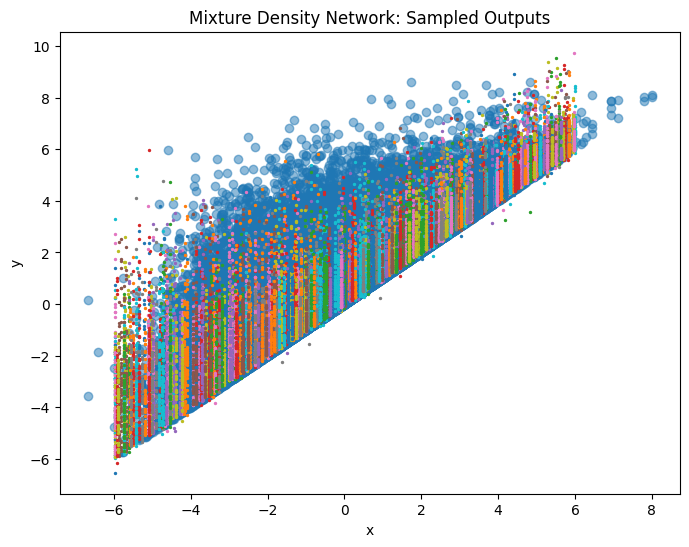

In [ ]:
x_test = torch.rand(500, 1)*12-6.0
pi, mu, sigma = Given_min_model(x_test)


# Sample 'num_samples' values for each of the 500 x_test values
num_samples = 50  # Input parameter for number of samples to generate
y_samples = []

for i in range(x_test.shape[0]):
    dist_type = "Normal"
    y_samples.append(sample_from_combined_pdf(pi[i:i+1, :], mu[i:i+1, :], sigma[i:i+1, :], num_samples,disttype = dist_type).detach().numpy())

# Plotting the results
plt.figure(figsize=(8, 6))
plt.scatter(x_train.numpy(), y_train.numpy(), alpha=0.5, label='Training Data')

# Loop over x_test and corresponding y_samples to plot individual samples
for i, y_s in enumerate(y_samples):
    plt.scatter(np.repeat(x_test[i].numpy(), num_samples), y_s, s=2, label=f'Sample {i+1}')

plt.title('Given min model: Sampled Outputs')
plt.xlabel('min')
plt.ylabel('max')
plt.show()


Save the weights of the N.N.

In [ ]:
# Saving the trained model
torch.save(Given_min_model.state_dict(), 'Given_min_model.pth')

Making the object `Given_max_model` to find the distribution of minimum extremums given the maximum extremums.

In [ ]:
Given_max_model = MDN(input_dim=1,num_gaussians=5)
optimizer = optim.Adam(Given_max_model.parameters(), lr=0.01)

x_train = torch.tensor(max_values.reshape(-1,1), dtype=torch.float32)
y_train = torch.tensor(min_values.reshape(-1,1), dtype=torch.float32)

In [ ]:
# Training loop
epochs = 10000
for epoch in range(epochs):
    optimizer.zero_grad()
    pi, mu, sigma = Given_max_model(x_train)
    dist_type = "Normal"
    loss = mdn_loss(pi, mu, sigma, y_train, dist_type)
    loss.backward()
    optimizer.step()
    if epoch % 50 == 0:
        print(f'Epoch {epoch}, Loss: {loss.item():.4f}')


Epoch 0, Loss: 2.4731
Epoch 50, Loss: 1.2535
Epoch 100, Loss: 1.1270
Epoch 150, Loss: 1.1777
Epoch 200, Loss: 1.1478
Epoch 250, Loss: 1.1130
Epoch 300, Loss: 1.0992
Epoch 350, Loss: 1.1137
Epoch 400, Loss: 1.0841
Epoch 450, Loss: 1.0955
Epoch 500, Loss: 1.0894
Epoch 550, Loss: 1.0650
Epoch 600, Loss: 1.0807
Epoch 650, Loss: 1.0787
Epoch 700, Loss: 1.0824
Epoch 750, Loss: 1.0794
Epoch 800, Loss: 1.1447
Epoch 850, Loss: 1.0810
Epoch 900, Loss: 1.0749
Epoch 950, Loss: 1.0686
Epoch 1000, Loss: 1.0662
Epoch 1050, Loss: 1.1286
Epoch 1100, Loss: 1.0754
Epoch 1150, Loss: 1.0639
Epoch 1200, Loss: 1.0630
Epoch 1250, Loss: 1.0972
Epoch 1300, Loss: 1.0667
Epoch 1350, Loss: 1.0805
Epoch 1400, Loss: 1.0840
Epoch 1450, Loss: 1.0898
Epoch 1500, Loss: 1.0905
Epoch 1550, Loss: 1.0664
Epoch 1600, Loss: 1.0812
Epoch 1650, Loss: 1.0707
Epoch 1700, Loss: 1.0805
Epoch 1750, Loss: 1.0660
Epoch 1800, Loss: 1.0541
Epoch 1850, Loss: 1.0882
Epoch 1900, Loss: 1.0695
Epoch 1950, Loss: 1.0743
Epoch 2000, Loss: 1.079

In case you want to use the model without training it, just read the weights of the model from the bottom section.

In [ ]:
'''If we want do inferencing'''
import os
path_ = os.getcwd()
path_ = os.path.join(path_,"Given_max_model.pth")
Given_max_model.load_state_dict(torch.load(path_))
Given_max_model.eval()

MDN(
  (fc): Sequential(
    (0): Linear(in_features=1, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=32, bias=True)
    (3): ReLU()
    (4): Linear(in_features=32, out_features=32, bias=True)
    (5): ReLU()
    (6): Linear(in_features=32, out_features=32, bias=True)
    (7): ReLU()
    (8): Linear(in_features=32, out_features=32, bias=True)
    (9): ReLU()
  )
  (pi_layer): Linear(in_features=32, out_features=5, bias=True)
  (mu_layer): Linear(in_features=32, out_features=5, bias=True)
  (sigma_layer): Linear(in_features=32, out_features=5, bias=True)
)

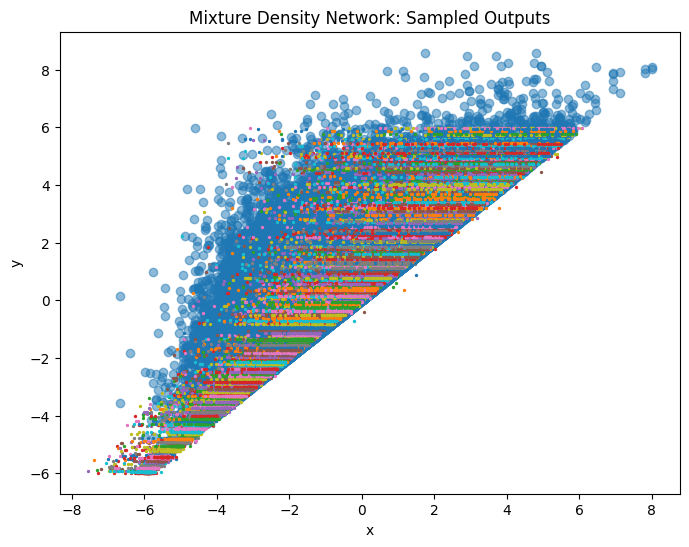

In [ ]:
x_test = torch.rand(500, 1)*12-6.0
pi, mu, sigma = Given_max_model(x_test)
# Sample 'num_samples' values for each of the 500 x_test values
num_samples = 50  # Input parameter for number of samples to generate
y_samples = []

for i in range(x_test.shape[0]):
    dist_type = "Normal"
    y_samples.append(sample_from_combined_pdf(pi[i:i+1, :], mu[i:i+1, :], sigma[i:i+1, :], num_samples,disttype = dist_type).detach().numpy())

# Plotting the results
plt.figure(figsize=(8, 6))
plt.scatter(y_train.numpy(),x_train.numpy() , alpha=0.5, label='Training Data')

# Loop over x_test and corresponding y_samples to plot individual samples
for i, y_s in enumerate(y_samples):
    plt.scatter(y_s, np.repeat(x_test[i].numpy(), num_samples), s=2, label=f'Sample {i+1}')

plt.title('Given max model: Sampled Outputs')
plt.xlabel('min')
plt.ylabel('max')
plt.show()

In [ ]:
# Saving the trained model
torch.save(Given_max_model.state_dict(), 'Given_max_model.pth')

Start modeling the distribution of $\text{min}\{ |\text{d}u^{\prime}_{NL_{\text{min}}}|, |\text{d}u^{\prime}_{NL_{\text{max}}}|\}/u_{\tau}$ vs $|\text{d}u^{\prime}_{NN}|/(\Delta \text{x}_{\text{data}}u_{\tau})$ (Fig5.)

In [ ]:
duwrtlocalmaxmin_HotWT7 = duwrtlocalmaxmin_HotWT7_list[0]/VF_HotWT7_u_tau
duNN_HotWT7 = duNN_HotWT7_list[0]/(VF_HotWT7_u_tau*res_WT7[0,0])



x_train = torch.tensor(duwrtlocalmaxmin_HotWT7.reshape(-1,1), dtype=torch.float32)
y_train = torch.tensor(duNN_HotWT7.reshape(-1,1), dtype=torch.float32)




# nonzero_mask = (y_train != 0).squeeze()

# # # Filter both x_train and y_train using the mask
# x_train = x_train[nonzero_mask]
# y_train= y_train[nonzero_mask]

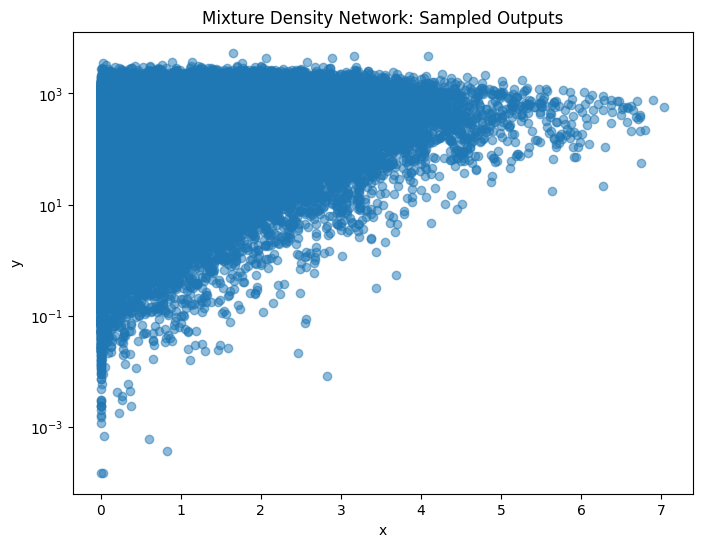

In [ ]:
plt.figure(figsize=(8, 6))
plt.scatter(x_train.numpy(), y_train.numpy(), alpha=0.5, label='Training Data')
plt.yscale('log')
plt.title('Distribution of minimum velocity differences to local extremums vs ' \
'velocity gradient to nearest sample point')
plt.xlabel('min\{ NLmin, NLmax \}')
plt.ylabel('duNN/(u_tau*res)')
plt.show()

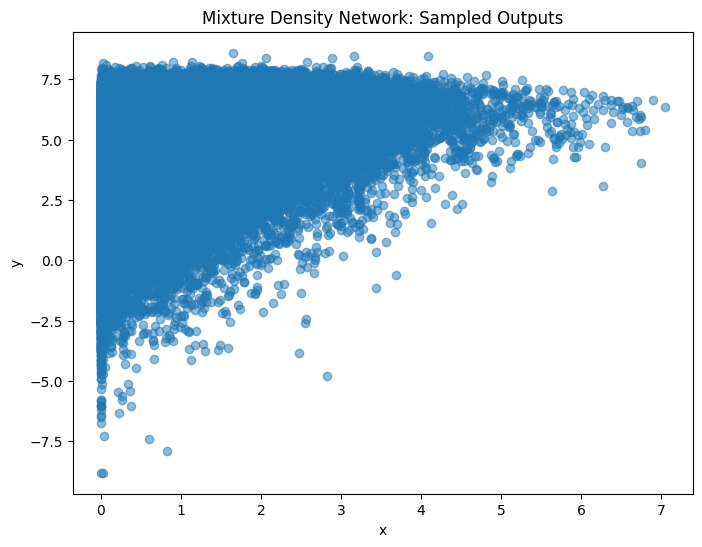

In [ ]:
plt.figure(figsize=(8, 6))
plt.scatter(x_train.numpy(), np.log(y_train.numpy()), alpha=0.5, label='Training Data')
plt.title('Distribution of minimum velocity differences to local extremums vs ' \
'log of velocity gradient to nearest sample point')
plt.xlabel('min\{ NLmin, NLmax \}')
plt.ylabel('duNN/(u_tau*res)')
plt.show()

In [ ]:
Given_dist_NLmin_NLmax_model = MDN(input_dim= 1,num_gaussians= 5)
optimizer = optim.Adam(Given_dist_NLmin_NLmax_model.parameters(), lr=0.01)

x_train = torch.tensor(duwrtlocalmaxmin_HotWT7.reshape(-1,1), dtype=torch.float32)
y_train = torch.log(torch.tensor(duNN_HotWT7.reshape(-1,1), dtype=torch.float32)+1e-10)

In [ ]:
# Training loopl
epochs = 10000
for epoch in range(epochs):
    optimizer.zero_grad()
    pi, mu, sigma = Given_dist_NLmin_NLmax_model(x_train)
    dist_type = "Normal"
    loss = mdn_loss(pi, mu, sigma, y_train, dist_type)
    loss.backward()
    optimizer.step()
    if epoch % 50 == 0:
        print(f'Epoch {epoch}, Loss: {loss.item():.4f}')

Epoch 0, Loss: 12.0055
Epoch 50, Loss: 1.4770
Epoch 100, Loss: 1.3677
Epoch 150, Loss: 1.3503
Epoch 200, Loss: 1.3477
Epoch 250, Loss: 1.3404
Epoch 300, Loss: 1.3376
Epoch 350, Loss: 1.3368
Epoch 400, Loss: 1.3337
Epoch 450, Loss: 1.3402
Epoch 500, Loss: 1.3303
Epoch 550, Loss: 1.3273
Epoch 600, Loss: 1.3260
Epoch 650, Loss: 1.3457
Epoch 700, Loss: 1.3231
Epoch 750, Loss: 1.3241
Epoch 800, Loss: 1.3245
Epoch 850, Loss: 1.3219
Epoch 900, Loss: 1.3207
Epoch 950, Loss: 1.3245
Epoch 1000, Loss: 1.3201
Epoch 1050, Loss: 1.3213
Epoch 1100, Loss: 1.3192
Epoch 1150, Loss: 1.3189
Epoch 1200, Loss: 1.3188
Epoch 1250, Loss: 1.3226
Epoch 1300, Loss: 1.3164
Epoch 1350, Loss: 1.3230
Epoch 1400, Loss: 1.3146
Epoch 1450, Loss: 1.3133
Epoch 1500, Loss: 1.3240
Epoch 1550, Loss: 1.3069
Epoch 1600, Loss: 1.3081
Epoch 1650, Loss: 1.3099
Epoch 1700, Loss: 1.3088
Epoch 1750, Loss: 1.3124
Epoch 1800, Loss: 1.3070
Epoch 1850, Loss: 1.3014
Epoch 1900, Loss: 1.3097
Epoch 1950, Loss: 1.3095
Epoch 2000, Loss: 1.30

In [ ]:
'''If we want do inferencing'''
import os
path_ = os.getcwd()
path_ = os.path.join(path_,"Given_dist_NLmin_NLmax_model.pth")
Given_dist_NLmin_NLmax_model.load_state_dict(torch.load(path_))
Given_dist_NLmin_NLmax_model.eval()

MDN(
  (fc): Sequential(
    (0): Linear(in_features=1, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=32, bias=True)
    (3): ReLU()
    (4): Linear(in_features=32, out_features=32, bias=True)
    (5): ReLU()
    (6): Linear(in_features=32, out_features=32, bias=True)
    (7): ReLU()
    (8): Linear(in_features=32, out_features=32, bias=True)
    (9): ReLU()
  )
  (pi_layer): Linear(in_features=32, out_features=5, bias=True)
  (mu_layer): Linear(in_features=32, out_features=5, bias=True)
  (sigma_layer): Linear(in_features=32, out_features=5, bias=True)
)

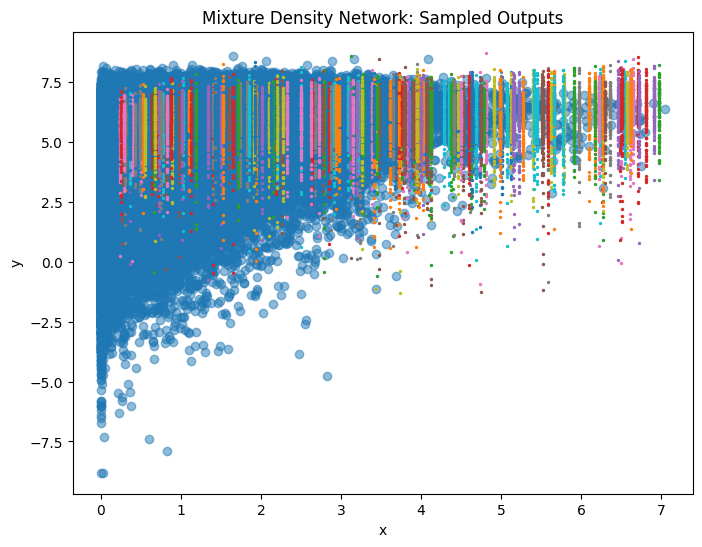

In [ ]:
x_test = torch.rand(200, 1)*7
pi, mu, sigma = Given_dist_NLmin_NLmax_model(x_test)


# Sample 'num_samples' values for each of the 500 x_test values
num_samples = 100  # Input parameter for number of samples to generate
y_samples = []

for i in range(x_test.shape[0]):
    dist_type = "Normal"
    y_samples.append(sample_from_combined_pdf(pi[i:i+1, :], mu[i:i+1, :], sigma[i:i+1, :], num_samples,disttype = dist_type).detach().numpy())

# Plotting the results
plt.figure(figsize=(8, 6))
plt.scatter(x_train.numpy(), y_train.numpy(), alpha=0.5, label='Training Data')

# Loop over x_test and corresponding y_samples to plot individual samples
for i, y_s in enumerate(y_samples):
    plt.scatter(np.repeat(x_test[i].numpy(), num_samples), y_s, s=2, label=f'Sample {i+1}')

# plt.yscale('log')
plt.xlabel('min\{ NLmin, NLmax \}')
plt.ylabel('duNN/(u_tau*res)')
plt.show()



In [ ]:
# Saving the trained model
torch.save(Given_dist_NLmin_NLmax_model.state_dict(), 'Given_dist_NLmin_NLmax_model.pth')